In [ ]:
!pip install -U spacy pyLDAvis gensim
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 47.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 92.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from google.colab import drive
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from gensim import corpora, models
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models
from tqdm import tqdm
tqdm.pandas()

drive.mount('/content/drive')
emails_body = pd.read_csv("/content/drive/MyDrive/emails_with_body_30k.csv")


Mounted at /content/drive


## Preprocessing

In [ ]:
enron_stopwords = set([
    'enron', 'attached', 'houston', 'please', 'thank', 'regards',
    'forwarded', 'original', 'email', 'message', 'subject', 'mailto',
    'sent', 'pm', 'am', 'also', 'let', 'know', 'get', 'one', 'would',
    'could', 'us', 'need', 'make', 'see', 'appreciate'
])
stop_words = STOP_WORDS.union(enron_stopwords)

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatize_text(text):
    if not isinstance(text, str):
        return ""
    doc = nlp(text.lower())
    return " ".join([token.lemma_ for token in doc if token.is_alpha])

def remove_stopwords(text):
    if isinstance(text, str):
        return " ".join([w for w in text.split() if w.lower() not in stop_words])
    return ""


emails_body = emails_body.drop(columns=["final_main", "sentences"])
emails_body = emails_body[emails_body["body"].notna()]
emails_body = emails_body[emails_body["body"].str.strip() != ""]

emails_body = emails_body[
    emails_body["body"].str.split().str.len().between(10, 1000)
]

emails_body["subject_body"] = (
    emails_body["subject"].fillna("").str.lower() + " " + emails_body["body"]
)

emails_body['clean_tokens'] = (
    emails_body['subject_body']
    .progress_apply(lemmatize_text)
    .progress_apply(remove_stopwords)
)


/tmp/ipython-input-2-4018779729.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emails_body["subject_body"] = (
100%|██████████| 19988/19988 [00:00<00:00, 55155.61it/s]


## Build Corpus and Dictionary

In [ ]:
tokenized_docs = emails_body['clean_tokens'].apply(lambda x: x.split()).tolist()

dictionary = corpora.Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]


## Optimize Topic Number

In [ ]:
# COHERENCE EVALUATION
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    coherence_values = []
    models_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)
        models_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return models_list, coherence_values

lda_models, coherence_scores = compute_coherence_values(dictionary, corpus, tokenized_docs, limit=30)


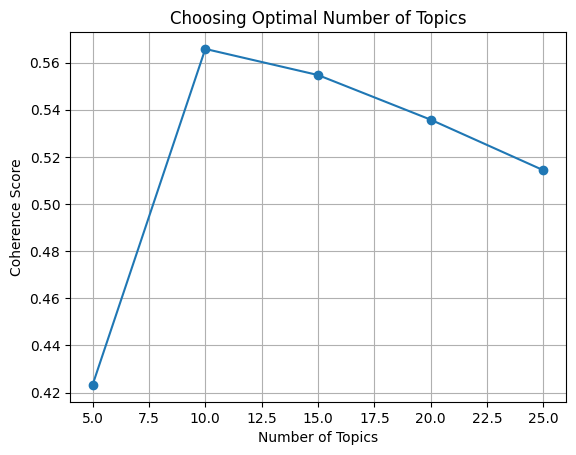

In [ ]:
import matplotlib.pyplot as plt

x = range(5, 30, 5)
plt.plot(x, coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Choosing Optimal Number of Topics")
plt.grid(True)
plt.show()


In [ ]:
best_index = coherence_scores.index(max(coherence_scores))
optimal_model = lda_models[best_index]
print(f"Best topic count: {x[best_index]}")


Best topic count: 10


In [ ]:
topics = optimal_model.print_topics(num_words=10)
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

Topic 0: 0.026*"agreement" + 0.016*"mail" + 0.014*"e" + 0.014*"attach" + 0.012*"draft" + 0.011*"credit" + 0.011*"copy" + 0.010*"review" + 0.010*"letter" + 0.010*"document"
Topic 1: 0.033*"gas" + 0.030*"deal" + 0.014*"price" + 0.013*"day" + 0.011*"month" + 0.009*"contract" + 0.009*"volume" + 0.008*"daily" + 0.008*"capacity" + 0.007*"pipeline"
Topic 2: 0.021*"company" + 0.019*"business" + 0.013*"energy" + 0.013*"group" + 0.010*"new" + 0.010*"management" + 0.010*"market" + 0.010*"million" + 0.010*"risk" + 0.008*"trading"
Topic 3: 0.010*"year" + 0.008*"program" + 0.008*"free" + 0.007*"work" + 0.007*"team" + 0.007*"time" + 0.007*"course" + 0.007*"new" + 0.006*"information" + 0.006*"help"
Topic 4: 0.029*"request" + 0.025*"update" + 0.021*"report" + 0.018*"database" + 0.017*"list" + 0.016*"send" + 0.014*"file" + 0.012*"attach" + 0.012*"alias" + 0.011*"eol"
Topic 5: 0.014*"information" + 0.013*"access" + 0.012*"employee" + 0.011*"service" + 0.010*"use" + 0.010*"site" + 0.010*"available" + 0.01

In [ ]:
from gensim.models import CoherenceModel

print(f"\nPerplexity: {optimal_model.log_perplexity(corpus)}")

coherence_model = CoherenceModel(model=optimal_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"\nCoherence Score (c_v): {coherence_score:.4f}")



Perplexity: -7.107373481646947

Coherence Score (c_v): 0.5658


While there's no fixed "good" threshold, the value for **perplexity** suggests the model has reasonably learned the word distributions across topics — especially since it's not dramatically high or flat.
**Coherence socore** falls in the **Good** range, this means the  topics are semantically meaningful and interpretable to humans.


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, dictionary)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.085151  0.010148       1        1  16.776166
0     -0.114208  0.058909       2        1  13.764910
7     -0.077009 -0.159040       3        1  13.503980
2     -0.097068 -0.148480       4        1  12.807998
1     -0.067201 -0.073659       5        1  11.076388
3     -0.128677 -0.060014       6        1  10.338664
5     -0.070135  0.080753       7        1   8.958790
4      0.015577  0.275876       8        1   5.248632
8      0.191681  0.154155       9        1   4.441875
6      0.432191 -0.138649      10        1   3.082597, topic_info=            Term         Freq        Total Category  logprob  loglift
43      schedule  4480.000000  4480.000000  Default  30.0000  30.0000
395         hour  2145.000000  2145.000000  Default  29.0000  29.0000
2265      outage  2120.000000  2120.000000  Default  28.0000  28.0000
118         date  2455.000000  2455.000000  Default  27.0000  27.0000
293          gas  3604.000000  3604.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
224         load   202.396894   546.442880  Topic10  -4.7988   2.4862
277   california   321.055253  2148.380433  Topic10  -4.3374   1.5785
46          term   240.569370  1476.567943  Topic10  -4.6260   1.6649
186         file   206.567975  1429.657065  Topic10  -4.7784   1.5448
214       energy   209.666283  3318.033951  Topic10  -4.7635   0.7178

[700 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1999      2  0.991912         abb
967       2  0.978947  acceptance
165       3  0.142845      access
165       6  0.019974      access
165       7  0.581063      access
...     ...       ...         ...
70        3  0.130961        year
70        4  0.262267        year
70        5  0.092362        year
70        6  0.293629        year
70        7  0.114763        year

[1685 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 8, 3, 2, 4, 6, 5, 9, 7])

## TF-IDF Setup (V2)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

documents = [" ".join(doc) for doc in tokenized_docs]

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_vocab = set(tfidf_vectorizer.get_feature_names_out())

filtered_docs = [[word for word in doc if word in tfidf_vocab] for doc in tokenized_docs]

dictionary_tfidf = corpora.Dictionary(filtered_docs)
dictionary_tfidf.filter_extremes(no_below=10, no_above=0.5)
corpus_tfidf = [dictionary_tfidf.doc2bow(text) for text in filtered_docs]

lda_tfidf = models.LdaModel(corpus=corpus_tfidf, id2word=dictionary_tfidf, num_topics=10, passes=10, random_state=42)

## Bigram/Trigram Setup (V3)

In [ ]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

bigram = Phrases(tokenized_docs, min_count=10, threshold=50)
trigram = Phrases(bigram[tokenized_docs], threshold=50)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

bigram_docs = [bigram_mod[doc] for doc in tokenized_docs]
trigram_docs = [trigram_mod[bigram_mod[doc]] for doc in tokenized_docs]

dictionary_bigram = corpora.Dictionary(bigram_docs)
dictionary_bigram.filter_extremes(no_below=10, no_above=0.5)
corpus_bigram = [dictionary_bigram.doc2bow(text) for text in bigram_docs]

dictionary_trigram = corpora.Dictionary(trigram_docs)
dictionary_trigram.filter_extremes(no_below=10, no_above=0.5)
corpus_trigram = [dictionary_trigram.doc2bow(text) for text in trigram_docs]

lda_bigram = models.LdaModel(corpus=corpus_bigram, id2word=dictionary_bigram, num_topics=10, passes=10, random_state=42)
lda_trigram = models.LdaModel(corpus=corpus_trigram, id2word=dictionary_trigram, num_topics=10, passes=10, random_state=42)


In [ ]:
def evaluate_model(model, texts, corpus, dictionary):
    cm = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = cm.get_coherence()
    perplexity = model.log_perplexity(corpus)
    return round(coherence, 4), round(perplexity, 4)

coh_base, perp_base = evaluate_model(optimal_model, tokenized_docs, corpus, dictionary) # Baseline
coh_tfidf, perp_tfidf = evaluate_model(lda_tfidf, filtered_docs, corpus_tfidf, dictionary_tfidf) # V2: TF-IDF
coh_bigram, perp_bigram = evaluate_model(lda_bigram, bigram_docs, corpus_bigram, dictionary_bigram) # V3: Bigrams
coh_trigram, perp_trigram = evaluate_model(lda_trigram, trigram_docs, corpus_trigram, dictionary_trigram) # V3: Trigrams

print("Model Comparison (Coherence ↑, Perplexity ↓)")
print(f"Baseline       → Coherence: {coh_base} | Perplexity: {perp_base}")
print(f"TF-IDF Filter  → Coherence: {coh_tfidf} | Perplexity: {perp_tfidf}")
print(f"Bigrams        → Coherence: {coh_bigram} | Perplexity: {perp_bigram}")
print(f"Trigrams       → Coherence: {coh_trigram} | Perplexity: {perp_trigram}")


Model Comparison (Coherence ↑, Perplexity ↓)
Baseline       → Coherence: 0.5658 | Perplexity: -7.1074
TF-IDF Filter  → Coherence: 0.5227 | Perplexity: -7.2511
Bigrams        → Coherence: 0.5263 | Perplexity: -7.4972
Trigrams       → Coherence: 0.4884 | Perplexity: -7.5195


## Topic Naming


In [ ]:
def get_dominant_topic(bow, model):
    topic_dist = model.get_document_topics(bow)
    if not topic_dist:
        return -1, 0
    top_topic, prob = max(topic_dist, key=lambda x: x[1])
    return top_topic, prob

doc_topics = [get_dominant_topic(bow, optimal_model) for bow in corpus]
emails_body['dominant_topic'] = [t[0] for t in doc_topics]
emails_body['topic_confidence'] = [t[1] for t in doc_topics]

low_confidence = emails_body[emails_body['topic_confidence'] < 0.3]
low_confidence[['subject_body', 'dominant_topic', 'topic_confidence']].sample(5)


,subject_body,dominant_topic,topic_confidence
26695,"Louise As you requested, here is the link for...",3,0.242460
22548,re: enron online Please speak to Mark Taylor b...,5,0.298929
15761,news about american express member rewards stu...,1,0.246774
23796,"FYI. December 2000 HEADLINE: ""Perfection in C...",3,0.298993
5529,brent notes Sally Here is a rough draft of my ...,3,0.297396


In [ ]:
import plotly.graph_objects as go

fig2 = go.Figure()

fig2.add_trace(go.Histogram(
    x=emails_body['topic_confidence'],
    nbinsx=20,
    marker=dict(color='#900C3F', line=dict(color='white', width=1))
))

fig2.update_layout(
    title='Confidence in LDA Topic Assignment',
    xaxis_title='Dominant Topic Probability',
    yaxis_title='Number of Emails',
    title_font=dict(size=20, family='Times New Roman'),
    font=dict(size=14, family='Times New Roman'),
    plot_bgcolor='white',
    width=600,
    height=500,
)

fig2.show()


In [ ]:
low_confidence.shape

(613, 10)

In [ ]:
import plotly.express as px

topic_counts = emails_body['dominant_topic'].value_counts().sort_index()

fig1 = px.bar(
    x=topic_counts.index,
    y=topic_counts.values,
    labels={'x': 'Topic ID', 'y': 'Number of Emails'},
    title='Topic Distribution',
    text=topic_counts.values,
    color_discrete_sequence=['#900C3F'],
)

fig1.update_traces(textposition='outside')
fig1.update_layout(
    title_font=dict(size=20, family='Times New Roman'),
    font=dict(size=14, family='Times New Roman'),
    xaxis=dict(title_font=dict(size=16), tickmode='linear'),
    yaxis=dict(title_font=dict(size=16)),
    plot_bgcolor='white',
    width=600,
    height=500
)
fig1.show()


In [ ]:
pd.set_option('display.max_colwidth', None)
for topic in range(optimal_model.num_topics):
    print(f"\n--- Topic {topic} ---")
    sample = emails_body[emails_body['dominant_topic'] == topic].sample(3)
    display(sample[['subject_body', 'topic_confidence']])



--- Topic 0 ---


,subject_body,topic_confidence
27211,ge lm-6000 purchase contract for las vegas cogeneration ii project Bill Williams asked me to forward the attached execution form of the LM-6000 purchase contract. The second attachment is to be inserted as Exhibit H-2 in the contract.,0.758960
2650,"closing memorandum and no objection to forms letter Ladies and Gentlemen: We have enclosed initial drafts of the closing memorandum and of a letter from ENA confirming that it has no objection to and will not act in furtherance of frustrating execution of the financing documents between Salmon and PPL. Please review and advise of any comments. We await receipt of comments to the escrow disbursement instruction letter. Thank you. Carolyn M. Campbell King?& Spalding 713-276-7307 (phone) 713-751-3280 (fax) ccampbell@kslaw.com <mailto:ccampbell@kslaw.com> Enclosures: 140424v1 140366v4 Confidentiality Notice This message is being sent by or on behalf of a lawyer. It is intended exclusively for the individual or entity to which it is addressed. This communication may contain information that is proprietary, privileged or confidential or otherwise legally exempt from disclosure. If you are not the named addressee, you are not authorized to read, print, retain, copy or disseminate this message or any part of it. If you have received this message in error, please notify the sender immediately by e-mail and delete all copies of the message.",0.878001
22782,"mariner confirm Judy, I added the language for release by Mariner that we discussed. I put a 3 day threshold in the language. Please review and lets discuss.",0.797539



--- Topic 1 ---


,subject_body,topic_confidence
24332,"december 2000 --- sithe gas sales agreement volumes & buyback\n volumes for mw turndown For the December sale to Sithe under our long term gas sales agreement, please use the following volumes for every day in the month: Chippawa: 28,400 Dth/day PEPL: 37,776 Dth/day ANR-OK 41,933 Dth/day ANR-LA: 83,915 Dth/day For the volumes that ENA would buy back from Sithe in the field due to the MW Turndown deal, please use the following volumes: Chippawa: 0 Dth/day PEPL: 0 Dth/day ANR-OK 24,554 Dth/day ANR-LA: 83,915 Dth/day Total 108,469 Dth/day We are meeting with John Lavorato at 9:30 this morning to talk about hedging the power side of this transaction.",0.798228
7001,"re: first delivery - helmerich & payne Vance, Deal # 621422 has been created and entered in Sitara.",0.849975
25826,"restructuring today, tuesday november 14, 2000 (see attached file: rt001114.pdf) Thank you, Season Hawksley US Publishing 1-800-486-8201 www.restructuringtoday.com season@restructuringtoday.com - rt001114.pdf",0.272254



--- Topic 2 ---


,subject_body,topic_confidence
4764,energy analysis Attached you will find last week's energy analysis which includes information about Vicente Fox's Energy team.,0.496857
19072,"sp 18th <<Southpoint Gas Model.xls>> Lisa Reichel Mgr., Corporate Risk Management Calpine Corporation 700 Louisiana Street, Suite 2700 Houston, Texas 77002 713-830-8841 Direct 713-830-8902 Fax - Southpoint Gas Model.xls",0.387935
10956,fw: crescendo I understand from Janet Place that this is not a Northern Border project but rather a North America project and that she is leaving you a voice mail regarding this. I assume that either you or Andy Edison will follow up. JIm,0.449885



--- Topic 3 ---


,subject_body,topic_confidence
4812,"laptop found To All, A computer laptop was found last week at the Haas School of Business. Please call Jennifer Jensen at 642-9106 to claim the laptop.",0.493800
11638,"intern compensation Sally: Summer Analysts will benefit from our recent compensation changes. Their monthly salary this summer will be $3333.00 Please let me know if you have any questions. Thank you, and I look forward to seeing you in Austin Monday. lexi 3-4585 cell: 281/793-1097",0.650225
1761,re: lunch? I AM important around here. I am definitely up for lunch. How's 11:30 suit you? If that's not good just give me a time.,0.887470



--- Topic 4 ---


,subject_body,topic_confidence
14990,"fw: enron corp. Brent, Now that Clement has approved of all changes, please advise if I should request issuance of this Enron Corp. Guaranty???",0.421623
19970,curve file access Everybody should have access to the curve file location; O:/ERMS/Erms_Adm/UBS/UBS Curves/East/EastBasis/0202/EastBasis0211 - Sandra O:/ERMS/Erms_Adm/UBS/UBS Curves/East/MktEastBasisIndexY/0202/Mktbasis1102 - Jon O:/ERMS/Erms_Adm/UBS/UBS Curves/East/EastIndexY/0202/EastIndexY - ? ??? O:/ERMS/Erms_Adm/UBS/UBS Curves/East/EastIntra/0202/EastIntraGDP - Chuck You may need to log off and back on if you have not done so since 12:00. Please make sure that any links that you have set up are still there. Thanks and I hope all went well today.,0.540164
6637,"eol Scott, I currently have view only access for EOL. Can you set me up with a transaction id?",0.533693



--- Topic 5 ---


,subject_body,topic_confidence
15915,"oasis site feedback (/oasis/secure/transmission/newreservation.asp) If you have discovered a bug with the OASIS web site, please include as much information about what you were trying to do and the error message returned. I cannot purchase any daily transmission on the AZPS oasis site. Error is below: An error occurred in processing this page. Please contact the server's administrator if this problem persists. Please let me know what I can do.",0.448586
12316,"new intranet site TJ, Could you please send this to the group. The new intranet site (phase 1) is ready and can be viewed from the following link. http://eastpower.dev.corp.enron.com/portal/default.aspx Many changes have taken place. We have a new look and a new architecture. Currently the only changes you can make is to the color scheme. You will notice 3 tabs across the top. These will be configurable to your personal needs. You will see that tab 3 is blank to show you that any content can be added. Please take a look and give us feedback. Without your input the site cannot grow to meet your needs.",0.537610
21338,"trv notification: (ng - propt p/l - 10/18/2001) The report named: NG - PROPT P/L <http://trv.corp.enron.com/linkFromExcel.asp?report_cd=11&report_name=NG+-+PROPT+P/L&category_cd=5&category_name=FINANCIAL&toc_hide=1&sTV1=5&TV1Exp=Y&current_efct_date=10/18/2001>, published as of 10/18/2001 is now available for viewing on the website.",0.935704



--- Topic 6 ---


,subject_body,topic_confidence
5885,start date: 1/13/02; hourahead hour: 22; Start Date: 1/13/02; HourAhead hour: 22; No ancillary schedules awarded. No variances detected.,0.935714
24730,start date: 2/5/02; hourahead hour: 11; Start Date: 2/5/02; HourAhead hour: 11; No ancillary schedules awarded. No variances detected. LOG MESSAGES: PARSING FILE -->> O: Portland WestDesk California Scheduling ISO Final Schedules 2002020511.txt ! ! !General SQL error. Couldn't update; currently locked by user 'admin' on machine 'NAHOU-TRDTS4'. Table ---- Energy Import/Export Schedule ---- *** Final schedule not found for preferred schedule. Details: TRANS_TYPE: FINAL SC_ID: ECTstNW MKT_TYPE: 2 TRANS_DATE: 2/5/02 TIE_POINT: MALIN_5_RNDMTN INTERCHG_ID: ENRJ_CISO_3000 ENGY_TYPE: FIRM,0.954730
11592,start date: 4/15/01; hourahead hour: 14; <codesite> Start Date: 4/15/01; HourAhead hour: 14; No ancillary schedules awarded. Variances detected. Variances detected in Energy Import/Export schedule. Variances detected in SC Trades schedule. LOG MESSAGES: PARSING FILE -->> O: Portland WestDesk California Scheduling ISO Final Schedules 2001041514.txt ---- Energy Import/Export Schedule ---- $$$ Variance found in table tblINTCHG_IMPEXP. Details: (Hour: 14 / Preferred: 12.00 / Final: 11.98) TRANS_TYPE: FINAL SC_ID: ECTRT MKT_TYPE: 2 TRANS_DATE: 4/15/01 TIE_POINT: PVERDE_5_DEVERS INTERCHG_ID: EPMI_CISO_LUCKY ENGY_TYPE: WHEEL ---- SC Trades Schedule ---- *** Final schedule not found for preferred schedule. Details: (Hour: 14 / Preferred: 10.00 / Final: 9.97) TRANS_TYPE: FINAL SC_ID: EPMI MKT_TYPE: 2 TRANS_DATE: 4/15/01 TRADING_SC: PGAE PNT_OF_INTRC: NP15 SCHED_TYPE: ENGY PURCH_SALE: 2 DEAL_NO: 1,0.986363



--- Topic 7 ---


,subject_body,topic_confidence
12398,call with gov davis Please see the attached document regarding the call to Gov.,0.481562
6872,"4 questions and answers Q1: What are the main reasons for having a common currency Euro for the EU? Transactions of money and trade will less expensive because currency exchange cost will disappear. Saves the costs of hedging exchange rate risks (some monetary, others due to the drain on managerial attention) or the risks of not heding fixed but adjustable rates. Makes price differences more transparent across borders, which may increase trade. Economists do not fully understand why, but beyond the measurable effects of the effects I just mentioned, a common currency increases trade even more than these slightly lower transaction costs can explain. The process of qualifying for unification also required lower inflation and deficits, which many economists and politicians desired. The main arguments for monetary unifications were political, not economic, having to do with integrating Western Europe. Q2: Beside losing its monetary authority, what are the reasons that the UK does not want to join the Euro? I believe the Government has a different opinion than the public. What are these arguments? As you note, the economic reason is fear of losing control over domestic monetary policy. As with the decision to join, the UK's decision not to join was largely political, choosing NOT to unify as rapidly with Europe on monetary and lots of other matters (social charter that may regulate working conditions, etc.). Q3: In my notes, I wrote ""You don't get rich by exporting -- you get rich in the short run by importing."" What do you mean? I said that unclearly. I should have said, ""You do not raise your standard of living by exporting; you raise it by importing."" At the same time, exports are the price of imports, so you raise your grandkids' standard of living by exporting intsead of borrowing to pay for the imports. (Unless the imports are high-value investment goods...) Q4: I also wrote in my notes: ""Trade deficits and exchange rates can't be used to describe a country's prosperity."" If trade deficits and exch. rates can't be used to describe prosperity, what is the best measure? At first GDP comes to mind, but in my day 2 notes, there are all sorts of reasons why GDP isn't a good measure, the most poignant one being: ""2 countries have the same GDP, but one country has twice as many people -- this country has lower per capita GDP, and is poorer than the first country."" CRUX: is per capita GDP a good measure of prosperity? Per capita is a pretty good measure of prosperity and living standards. The list we gave are all the components of ""the good life"" it leaves out. On average, rich nations have higher life expectancy, etc., so GDP per capita is not too misleading, but it clearly can be (as we pointed out). Thus, no single measure suffices, and a combination of measures can be useful.",0.427453
20739,re: public hydro data sources Thanks for the information. It will be very useful to the team! If you have any other questions please call me.,0.447438



--- Topic 8 ---


,subject_body,topic_confidence
12512,"database Maria, Hey, your database sucks! (j/k) Give me a ring when you get a chance. Mat",0.398222
19508,"supplemental weekend outage report for 4-20-01 through 4-23-01 ------------------------------------------------------------------------------ ------------------------ W E E K E N D S Y S T E M S A V A I L A B I L I T Y F O R April 20, 2001 5:00pm through April 23, 2001 12:00am ------------------------------------------------------------------------------ ------------------------ SCHEDULED SYSTEM OUTAGES: ARDMORE DATA CENTER - FACILITY OPERATIONS: No Scheduled Outages. AZURIX: No Scheduled Outages. EB34 DATA CENTER - FACILITY OPERATIONS: No Scheduled Outages. EDI SERVER: No Scheduled Outages. ENRON NORTH AMERICAN LANS: SEE ORIGINAL REPORT FIELD SERVICES: No Scheduled Outages. INTERNET: No Scheduled Outages. MESSAGING: SEE ORIGINAL REPORT MARKET DATA: No Scheduled Outages. NT: No Scheduled Outages. OS/2: No Scheduled Outages. OTHER SYSTEMS: ALSO SEE ORIGINAL REPORT Impact: CORP Time: Fri 4/20/2001 at 5:00:00 PM CT thru Mon 4/23/2001 at 8:00:00 AM CT Fri 4/20/2001 at 3:00:00 PM PT thru Mon 4/23/2001 at 6:00:00 AM PT Fri 4/20/2001 at 11:00:00 PM London thru Mon 4/23/2001 at 2:00:00 PM London Outage: SysAdmiral Maintenance Environments Impacted: SysAdmiral Users Purpose: SysAdmiral terminal server icons on General Cluster will not be available due to maintenance. Once the maintenance is completed the icons will point to the new 2.3.11 production and development environments. Backout: None Contact(s): Rusty Cheves 713-345-3798 SITARA: No Scheduled Outages. SUN/OSS SYSTEM: No Scheduled Outages.",0.968648
25408,"supplemental weekend outage report for 7-6-01 through 7-9-01 ------------------------------------------------------------------------------ ------------------------ W E E K E N D S Y S T E M S A V A I L A B I L I T Y F O R July 6, 2001 5:00pm through July 9, 2001 12:00am ------------------------------------------------------------------------------ ------------------------ ECS to ECN Network Interconnection July 14, 2001 This is a notification that the Enron Corp. I/T Networks team will be connecting the new building network infrastructure located in Enron Center South (ECS) to the existing Enron Center North (ECN) backbone network. While this activity is not expected to produce a disruption to network services, this notice is designed to alert the organization to our activities. No network hardware or systems are anticipated to be shutdown. The actual physical interconnection of the networks will be performed in the EB 34th floor Data Center. Interconnection activities are scheduled to occur the evening of July 14, 2001 starting from 7:00 p.m.(CT) and completing around 11:00 p.m. (CT). Application testing activities will begin at 11:00 p.m. (CT) once all network testing has completed. If you have any further questions, please contact Pete Castrejana at 713-410-0642 for more information. SCHEDULED SYSTEM OUTAGES: ARDMORE DATA CENTER - FACILITY OPERATIONS: No Scheduled Outages. AZURIX: No Scheduled Outages. EB34 DATA CENTER - FACILITY OPERATIONS: No Scheduled Outages. EDI SERVER: No Scheduled Outages. ENRON CENTER SOUTH DATA CENTER - FACILITY OPERATIONS: No Scheduled Outages ENRON NORTH AMERICAN LANS: ALSO SEE ORIGINAL REPORT Impact: EES Time: Fri 7/6/2001 at 5:00:00 PM CT thru Fri 7/6/2001 at 5:30:00 PM CT Fri 7/6/2001 at 3:00:00 PM PT thru Fri 7/6/2001 at 3:30:00 PM PT Fri 7/6/2001 at 11:00:00 PM London thru Fri 7/6/2001 at 11:30:00 PM London Outage: Reboot EES Houston Router Environments Impacted: EES Purpose: Maintenance Backout: None Contact(s): Garhett Clark 713-345-9953 FIELD SERVICES: No Scheduled Outages. INTERNET: ALSO SEE ORIGINAL REPORT Impact: CORP Time: Fri 7/6/2001 at 2:00:00 PM CT thru Fri 7/6/2001 at 10:00:00 PM CT Fri 7/6/2001 at 12:00:00 PM PT thru Fri 7/6/2001 at 8:00:00 PM PT Fri 7/6/2001 at 8:00:00 PM London thru Sat 7/7/2001 at 4:00:00 AM London Outage: NAHOU-WWC


--- Topic 9 ---


,subject_body,topic_confidence
19004,"re: elevator maintenance Gary, Yesterdays elevator problem was caused initially by a broken belt on the governor on Car # 21. This controls the speed of the car, and the car is designed to stop where it is if something happens to the governor rather than risk an overspeed condition. We have had the car thoroughly checked over today to see what else we could determine about yesterdays problems. The intercom in this car does not work, but the alarm bell does work. I can't explain why no one heard the bell. We have taken the car out of service until the intercom is repaired. There have been several changes within the Maintenance Department since the bankruptcy in December, but none that should have impacted the maintenance levels of the elevators. We have eliminated the 24 x 7 on site coverage by the Maintenance Department, and returned to an on call arrangement which we previously had until about a year ago. We had to reduce the size of our staff as did everyone else, and simply do not have enough people to adequately staff 24 x 7 any longer. We also had two full time Elevator Mechanics on site Monday through Friday during our peak. That, however, was when we had over 8,000 people in the building. During that time we had a lot of problems just because of the extremely heavy usage. Now that we have fewer than 3,000 people here, the usage does not warrant two full time mechanics, so we have cut back to one. The routine maintenance on the elevators is still accomplished on schedule by the one mechanic. Most of the other high rise buildings in town have either one or none. In the past the second mechanic was tied up with trouble calls which we have very few of now. While it is not required by code, we have always made it an internal practice to do a physical inspection of all of the elevators and test all of their functions on a weekly basis. This is generally accomplished by Security or Maintenance either on Friday or Saturday after hours, as you must recall them to the lobby to do this. The inspections were not completed this past Saturday. This would normally not be a significant issue, as routines are interrupted from time to time due to other occurring problems. Unfortunately this time it was significant. This past Sunday has pointed out several procedural issues that either need corrected or reviewed with our support personnel. I do not know what time it was determined that someone was stuck in the elevator, but Security contacted our on call person at approximately 11:45 A.M. The on call Tech then proceeded to the building arriving at about 12:25 P.M. Our person tried unsuccessfully to reset the elevator, and when that was not possible, he asked Security if Schindler was on their way. It was at that point the he learned that Schindler had not been contacted yet. Security then called Schindler at 12:37 p.m. and Schindler contacted their mechanic at 12:44 p.m. The Schindler tech arrived on site at 1:45 p.m. and had the person out of the elevator about 2:20 p.m. It is standing procedure for Security to contact Schindler immediately in the event of an entrapment. Failure to do this resulted in an extra hour before help arrived. I am reviewing procedures with the Security Supervisor to insure there are no delays in contacting the elevator service immediately in cases of an entrapment. We are also reviewing the routine inspection procedures on the elevators to insure that they are inspected weekly and taken out of service if the intercom does not work properly. Security will remain responsible for these inspections since they have people here at night. I sincerely regret the extreme inconvenience your employee went through yesterday, and I assure you we are taking every precaution to insure this does not happen again. Elevators will occasionally break, and there will occasionally be an entrapment, but 5 hours and no ability to communicate is not acceptable.",0.360563
25021,"re: ut general prese

In [ ]:
topic_labels = {
    0: "Contract & Document Review",
    1: "Gas Trading & Deal Management",
    2: "Business Operations & Market Analysis",
    3: "Team Coordination & Personal Updates",
    4: "Data Requests & Project Reports",
    5: "IT Access & System Notifications",
    6: "Scheduling & Time Reports",
    7: "Power Market & Regulatory Issues",
    8: "System Outages & Infrastructure Status",
    9: "Meetings & Scheduling Coordination"
}

emails_body["topic_label"] = emails_body["dominant_topic"].map(topic_labels)
emails_body[["clean_main_message","dominant_topic", "topic_label"]].head()


,clean_main_message,dominant_topic,topic_label
0,"Hello - In order to cross one more item off of the enovate setup list, I would like to pursue the initial capital contribution required under the LLC agreement of $100,000 from each member. Although we do not have loan facilities in place or final cash management protocol, I believe the initial funding can still take place. If anyone has any other thoughts please let me know. If not, I would like to schedule the initial funding for Friday, October 6th. I believe that Mary Lynne will prepare the necessary vouchers and journal entries. I am assuming that Enron MW, L.L.C., as Member, will be funding enovate, L.L.C. Does ENA then fund Enron MW, L.L.C.? (Kay? Mary Lynne?) As an update - Peoples' Board meets next Wednesday, Oct. 4th to approve the risk management policy. Assuming approval, enovate will be free to transact with third parties. Therefore, depending on payment terms, money will begin flowing through the enovate account. Therefore, any loan docs and service agreements should be in place by the second week of October. Any thoughts, please let me know. Thanks, Gregg",0,Contract & Document Review
1,Beavy and I changed the following deals for July and August. We took all the August activity to 0. This is how these deals should be balanced Deal 318562 with 318686. And 318691 with 318682. I'll look at the economics in the morning.,1,Gas Trading & Deal Management
2,"Eric- Here's the 10 year basis curves, per Ed. Note that the Carthage curve is calculated as a differential from Ship. It's based on an analysis of 1998 Gas Daily spreads. Thanks, James",1,Gas Trading & Deal Management
4,"Kevin, Rogers, and Dana -- We do not have to do or say anything since, per NEPOOL, Enron is in compliance. However, if you feel that NEPOOL participants are not trading with us and we need to make some statement, we can (if ok with legal). Let us know. Thanks.",0,Contract & Document Review
6,"Reagan C. Rorschach Enron North America 1400 Smith Street Houston, Texas 77002 713.345.3363",4,Data Requests & Project Reports


## Save the Model

In [ ]:
import pickle
drive_path = "/content/drive/MyDrive/LDA"
optimal_model.save(f"{drive_path}/lda_model.gensim")
dictionary.save(f"{drive_path}/lda_dictionary.dict")
with open(f"{drive_path}/topic_labels.pkl", "wb") as f:
    pickle.dump(topic_labels, f)
